_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Max Bardelang, Sascha Mühlinghaus

LLM Disclaimer: Copilot for commenting and ChatGPT for help with visualizations and bonus task.

# Coding Lab 3

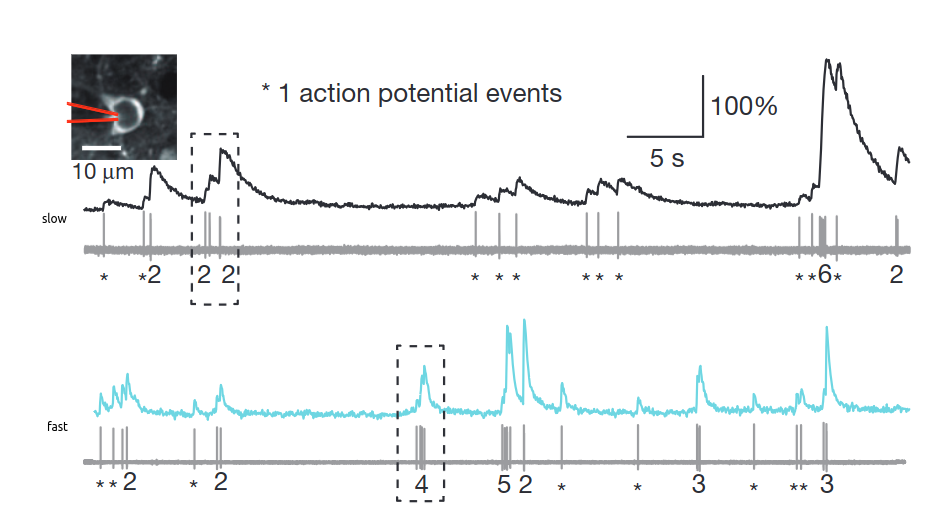

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-10 18:16:33CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

sklearn: 1.6.1

pandas    : 2.2.3
matplotlib: 3.10.1
scipy     : 1.13.0
seaborn   : 0.13.2
numpy     : 2.2.5

Watermark: 2.5.0



In [3]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [48]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gecamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
ogb_spikes

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
71981,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71982,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71983,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71984,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

In [49]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------

# 4-pole filter, as in Yaksi & Friedrich
ogb_calcium = pd.DataFrame(
    signal.decimate(ogb_calcium.fillna(0), q=4, n=4, axis=0),
    columns=ogb_calcium.columns,
)
gcamp_calcium = pd.DataFrame(
    signal.decimate(gcamp_calcium.fillna(0), q=4, n=4, axis=0),
    columns=gcamp_calcium.columns,
)

# for (discrete) spike signals, bin 4 timepoints into one
ogb_spikes = ogb_spikes.groupby(ogb_spikes.index // 4).any().astype(int)
gcamp_spikes = gcamp_spikes.groupby(gcamp_spikes.index // 4).any().astype(int)

# convert indices to real time
ogb_spikes.index = ogb_spikes.index / 25
gcamp_spikes.index = gcamp_spikes.index / 25

ogb_calcium.index = ogb_calcium.index / 25
gcamp_calcium.index = gcamp_calcium.index / 25

# zoom in on time window
start, stop = 15, 35
ogb, gcamp = ogb_spikes.loc[start:stop, "5"], gcamp_spikes.loc[start:stop, "6"]
ogb_c, gcamp_c = (
    ogb_calcium.loc[start:stop, "5"],
    gcamp_calcium.loc[start:stop, "6"],
)

# add offset
ogb_c = ogb_c + 0.5
gcamp_c = gcamp_c + 0.5

Text(0.5, 0, 'Time[s]')

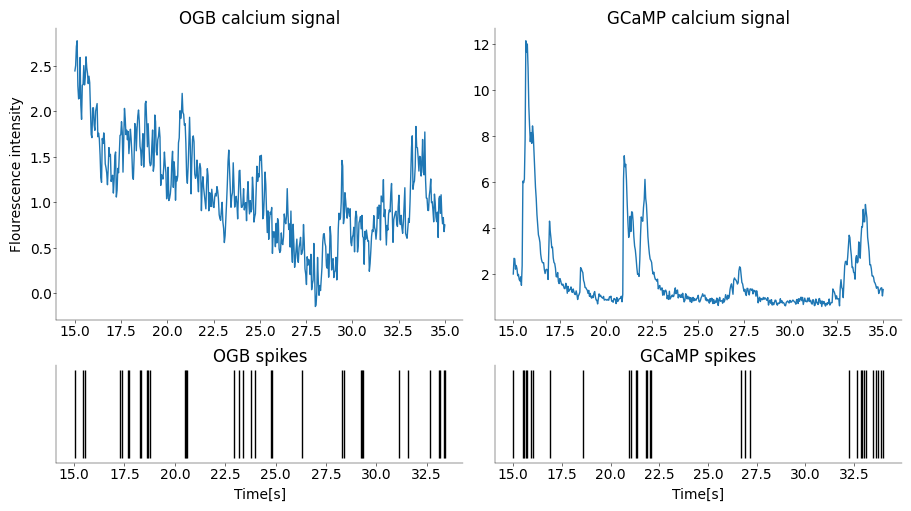

In [50]:
# --------------------
# Plot OGB data (1 pt)
# --------------------
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2,
    2,
    figsize=(9, 5),
    height_ratios=[3, 1],
    layout="constrained",  # sharex="col"
)

ax1.set_title("OGB calcium signal")
ax1.set_ylabel("Flourescence intensity")
ax1.plot(ogb_c)

ax3.set_title("OGB spikes")
ax3.set_yticks([])
ax3.vlines(
    ogb[ogb == 1].index.values,
    ymin=0,
    ymax=1,
    color="black",
)
# ax3.set_xticklabels(ogb[ogb == 1].index.values)
ax3.set_xlabel("Time[s]")

# ----------------------
# Plot GCamp data (1 pt)
# ----------------------
ax2.set_title("GCaMP calcium signal")
ax2.plot(gcamp_c)

ax4.set_title("GCaMP spikes")
ax4.vlines(gcamp[gcamp == 1].index, ymin=0, ymax=1, color="black")
ax4.set_yticks([])
ax4.set_xlabel("Time[s]")

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can be undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def filter_and_smooth(
    calcium: pd.Series,
    window_size: int = 5,
    cutoff: float = 1,
) -> tuple[pd.Series, pd.Series]:
    """
    Filter and smooth the calcium signal. Spikes are left unchanged, but a smoothing is applied for visualization.

    Parameters
    ----------
    calcium : pd.Series
        The calcium signal (indexed by time).
    window_size : int, optional
        The size of the smoothing window for the calcium signal, by default 5.
    cutoff : float, optional
        The cutoff frequency for the low-pass filter on the calcium signal, by default 0.1 Hz.

    Returns
    -------
    tuple[pd.Series, pd.Series]
        The filtered calcium signal and the (unchanged) spike train, both as pd.Series with original index.
    """
    # create a low-pass butterworth filter
    sampling_interval = calcium.index[1] - calcium.index[0]
    fs = 1 / sampling_interval
    b, a = signal.butter(N=4, Wn=cutoff, fs=fs, btype="low")

    # apply the low-pass filter to the calcium trace
    filtered_calcium = signal.filtfilt(b, a, calcium.values)

    # smoothing the calcium trace using a rolling window
    smoothed_calcium = calcium.rolling(
        window=window_size, center=True, min_periods=1
    ).mean()

    # return as series with original index
    return pd.Series(filtered_calcium, index=calcium.index), smoothed_calcium

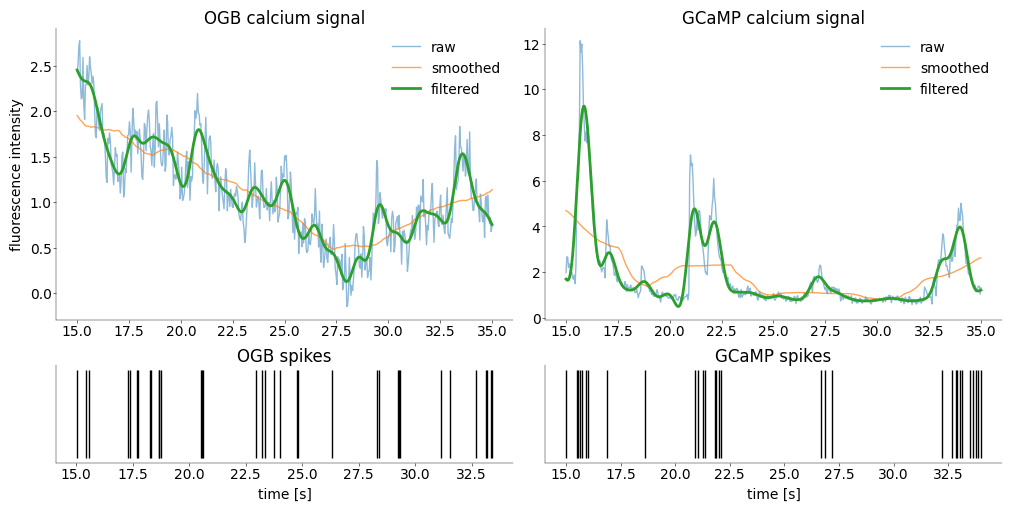

In [60]:
# apply filter and smoothing once
ogb_filtered, ogb_smoothed = filter_and_smooth(ogb_c, 100)
gcamp_filtered, gcamp_smoothed = filter_and_smooth(gcamp_c, 100)

# plot before and after filtering
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2,
    2,
    figsize=(10, 5),
    height_ratios=[3, 1],
    layout="constrained",
)

# plot OGB calcium signal
ax1.set_title("OGB calcium signal")
ax1.set_ylabel("fluorescence intensity")
ax1.plot(ogb_c, label="raw", alpha=0.5)
ax1.plot(ogb_smoothed, label="smoothed", alpha=0.7)
ax1.plot(ogb_filtered, label="filtered", linewidth=2)
ax1.legend()

# plot OGB spikes (unchanged, for visualization)
ax3.set_title("OGB spikes")
ax3.set_yticks([])
ax3.vlines(ogb[ogb == 1].index, ymin=0, ymax=1, color="black", label="spike times")
ax3.set_xlabel("time [s]")

# plot GCaMP calcium signal
ax2.set_title("GCaMP calcium signal")
ax2.plot(gcamp_c, label="raw", alpha=0.5)
ax2.plot(gcamp_smoothed, label="smoothed", alpha=0.7)
ax2.plot(gcamp_filtered, label="filtered", linewidth=2)
ax2.legend()

# plot GCaMP spikes (unchanged, for visualization)
ax4.set_title("GCaMP spikes")
ax4.set_yticks([])
ax4.vlines(gcamp[gcamp == 1].index, ymin=0, ymax=1, color="black", label="spike times")
ax4.set_xlabel("time [s]")

plt.show()

1) Explain your choices and discuss how it helps

The goal of the preprocessing is to improve the quality of the inferred spike trains. The filter and local averaging procedure are designed to reduce noise and enhance the signal-to-noise ratio of the calcium traces. Depending on the parameters chosen for the filter and local averaging, the preprocessing can help to smooth out rapid fluctuations in the calcium signal, making it easier to identify the underlying spike events. On the other hand, if the parameters are too aggressive, it may lead to loss of important information and make it harder to detect spikes. We are unsure where the sweet spot is, thats why we plotted the results in comparison to the original data.

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [7]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float = 0.0) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

        Parameters
        ----------

        ca: np.array, (n_points,)
            Calcium trace

        tau: floatogb_deconv = deconv_ca(ogb_calcium.loc[:, "5"], tau_ogb, dt)
    gcamp_deconv = deconv_ca(gcamp_calcium.loc[:, "6"], tau_gc
            decay constant of conv kernel

        dt: float
            sampling interval.

        Return
        ------

        sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    # n_points = ca.size

    # length of kernel in [s]
    t_max = 10
    t = np.linspace(0, t_max, t_max * int(1 / dt))
    kernel = np.exp(-tau * t)
    sp_hat = signal.deconvolve(ca, kernel)[0]
    return sp_hat

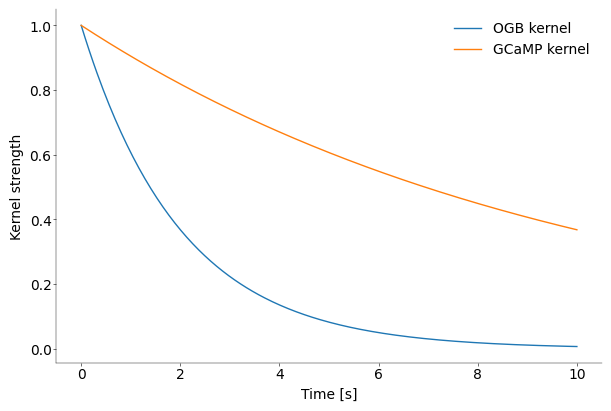

In [8]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")

# kernel lenght in [s]
t_max = 10

# sampling interval is 1/sampling_freq
dt = 1 / 25

# match sampling frequency of signal
t = np.linspace(0, t_max, t_max * int(1 / dt))

tau_ogb, tau_gcamp = 0.5, 0.1
kernel_OGB = np.exp(-tau_ogb * t)
kernel_GCaMP = np.exp(-tau_gcamp * t)
ax.plot(t, kernel_OGB, label="OGB kernel")
ax.plot(t, kernel_GCaMP, label="GCaMP kernel")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Kernel strength")
ax.legend()

### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

Text(0.5, 0, 'Time[s]')

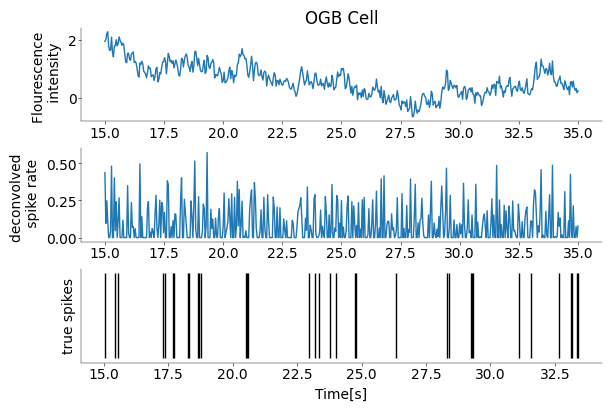

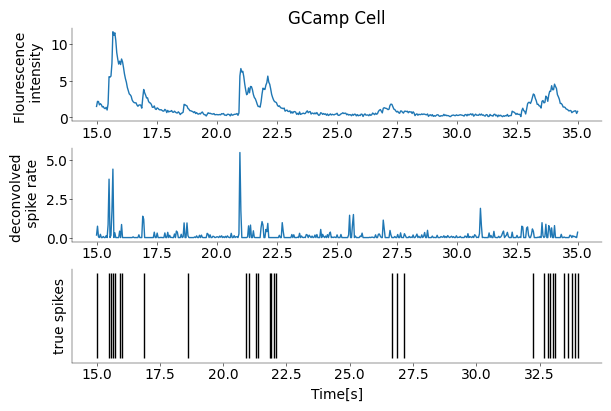

In [33]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------
start, stop = 15, 35

ogb_deconv = deconv_ca(ogb_calcium.loc[:, "5"], tau_ogb, dt)
gcamp_deconv = deconv_ca(gcamp_calcium.loc[:, "6"], tau_gcamp, dt)

# spiketrains can't be negative
ogb_deconv[ogb_deconv < 0] = 0
gcamp_deconv[gcamp_deconv < 0] = 0

# need to crop index, as deconvolved signal has marginally different array size
ogb_deconv = pd.DataFrame(ogb_deconv, index=ogb_calcium.index[: ogb_deconv.size])
gcamp_deconv = pd.DataFrame(
    gcamp_deconv, index=gcamp_calcium.index[: gcamp_deconv.size]
)
# true spikes
ogb, gcamp = ogb_spikes.loc[start:stop, "5"], gcamp_spikes.loc[start:stop, "6"]

fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    figsize=(6, 4),
    height_ratios=[1, 1, 1],
    gridspec_kw=dict(hspace=0),
)

# OGB Cell
ax1.set_title("OGB Cell")
ax1.set_ylabel("Flourescence \n intensity")
ax1.plot(ogb_calcium.loc[start:stop, "5"])
ax2.set_ylabel("deconvolved \n spike rate")
ax2.plot(ogb_deconv.loc[start:stop])
ax3.vlines(
    ogb[ogb == 1].index.values,
    ymin=0,
    ymax=1,
    color="black",
)
ax3.set_yticks([])
ax3.set_ylabel("true spikes")
ax3.set_xlabel("Time[s]")

fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    figsize=(6, 4),
    height_ratios=[1, 1, 1],
    gridspec_kw=dict(hspace=0),
)

# GCamp Cell
ax1.set_title("GCamp Cell")
ax1.set_ylabel("Flourescence \n intensity")
ax1.plot(gcamp_calcium.loc[start:stop, "6"])
ax2.set_ylabel("deconvolved \n spike rate")
ax2.plot(gcamp_deconv.loc[start:stop])
ax3.vlines(
    gcamp[gcamp == 1].index,
    ymin=0,
    ymax=1,
    color="black",
)
ax3.set_yticks([])
ax3.set_ylabel("true spikes")
ax3.set_xlabel("Time[s]")

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [10]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
import oopsi

In [11]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------
# d: reconstructed Spikes
ogb_d, _ = oopsi.fast(ogb_calcium.loc[:, "5"], dt=dt, iter_max=6)
gcamp_d, _ = oopsi.fast(gcamp_calcium.loc[:, "6"], dt=dt, iter_max=6)

In [12]:
# crop index, as deconvolved signal has marginally different array size
ogb_deconv = pd.DataFrame(ogb_d, index=ogb_calcium.index[: ogb_d.size])
gcamp_deconv = pd.DataFrame(gcamp_d, index=gcamp_calcium.index[: gcamp_d.size])

Text(0.5, 0, 'Time[s]')

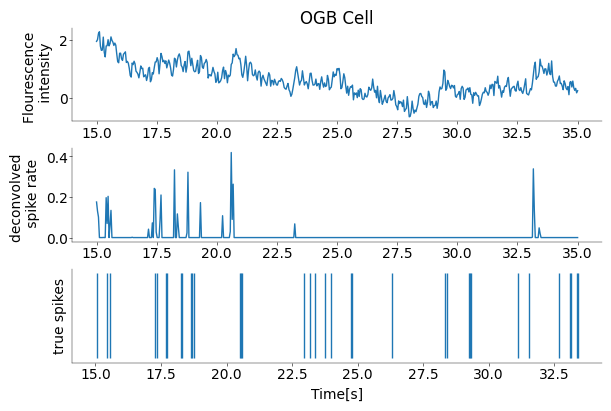

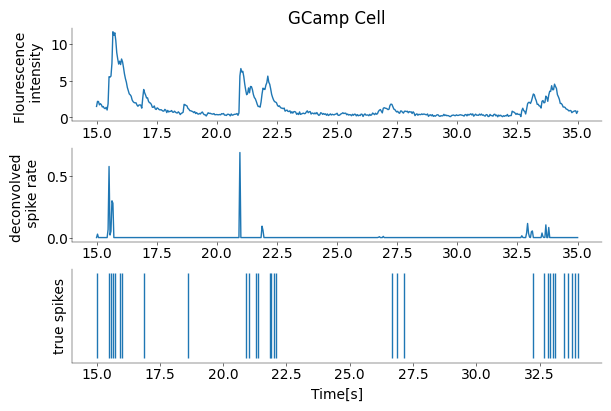

In [13]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell
ax1.set_title("OGB Cell")
ax1.set_ylabel("Flourescence \n intensity")
ax1.plot(ogb_calcium.loc[start:stop, "5"])
ax2.set_ylabel("deconvolved \n spike rate")
ax2.plot(ogb_deconv.loc[start:stop])
ax3.vlines(
    ogb[ogb == 1].index.values,
    ymin=0,
    ymax=1,
)
ax3.set_yticks([])
ax3.set_ylabel("true spikes")
ax3.set_xlabel("Time[s]")

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamP Cell
ax1.set_title("GCamp Cell")
ax1.set_ylabel("Flourescence \n intensity")
ax1.plot(gcamp_calcium.loc[start:stop, "6"])
ax2.set_ylabel("deconvolved \n spike rate")
ax2.plot(gcamp_deconv.loc[start:stop])
ax3.vlines(
    gcamp[gcamp == 1].index,
    ymin=0,
    ymax=1,
)
ax3.set_yticks([])
ax3.set_ylabel("true spikes")
ax3.set_xlabel("Time[s]")

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------
from scipy.stats import pearsonr

def evaluate_spike_train(true: np.ndarray, estimated: np.ndarray) -> tuple:
    """
    Compute the Pearson correlation between true and estimated spike trains.

    Parameters
    ----------
    true : np.ndarray
        Ground truth spike train (1D array).
    estimated : np.ndarray
        Estimated spike train (1D array).

    Returns
    -------
    tuple
        (correlation coefficient, p-value)
    """
    true = np.asarray(true, dtype=float).flatten()
    estimated = np.asarray(estimated, dtype=float).flatten()

    if true.shape != estimated.shape:
        raise ValueError("Shape mismatch: true and estimated must have same length.")

    # remove NaNs from estimate and align true values
    mask = ~np.isnan(estimated)
    true = true[mask]
    estimated = estimated[mask]

    return pearsonr(true, estimated)


def process_and_evaluate(
    ogb_calcium,
    gcamp_calcium,
    true_spikes_ogb,
    true_spikes_gcamp,
    tau_ogb,
    tau_gcamp,
    dt,
    oopsi,
    deconv_ca,
):
    """
    Process calcium signals for OGB and GCaMP indicators, apply deconvolution and OOPSI,
    and evaluate correlation with true spike trains.

    Parameters
    ----------
    ogb_calcium : pd.DataFrame
        Calcium traces for OGB indicator (columns = cells).
    gcamp_calcium : pd.DataFrame
        Calcium traces for GCaMP indicator (columns = cells).
    true_spikes_ogb : pd.DataFrame
        Ground truth spikes for OGB cells (columns = cells).
    true_spikes_gcamp : pd.DataFrame
        Ground truth spikes for GCaMP cells (columns = cells).
    tau_ogb : float
        Time constant for deconvolution of OGB signals.
    tau_gcamp : float
        Time constant for deconvolution of GCaMP signals.
    dt : float
        Time step size.
    oopsi : module
        OOPSI module with `.fast()` method.
    deconv_ca : function
        Deconvolution function: takes (trace, tau, dt) and returns estimate.

    Returns
    -------
    df_all : pd.DataFrame
        Combined DataFrame of OOPSI and deconvolution outputs for all cells.
    df_corr : pd.DataFrame
        DataFrame with evaluation results:
        columns = ['algorithm', 'correlation', 'indicator', 'cell_id']
    """
    df_all = pd.DataFrame()
    correlations = []

    # ogb loop
    for cell in ogb_calcium.columns:
        ogb_deconv = deconv_ca(ogb_calcium[str(cell)], tau_ogb, dt)
        ogb_deconv[ogb_deconv < 0] = 0
        ogb_d, _ = oopsi.fast(ogb_calcium[str(cell)], dt=dt, iter_max=6)

        # match index
        idx = ogb_calcium.index[: len(ogb_deconv)]
        ogb_deconv = pd.DataFrame(ogb_deconv, index=idx, columns=[f"deconv_OGB_{cell}"])
        ogb_d = pd.DataFrame(ogb_d[: len(idx)], index=idx, columns=[f"oops_OGB_{cell}"])

        # combine all outputs
        df_all = pd.concat([df_all, ogb_d, ogb_deconv], axis=1)

        # evaluate
        true = true_spikes_ogb[str(cell)].values[: len(idx)]
        est_oops = ogb_d.values.flatten()
        est_deconv = ogb_deconv.values.flatten()

        correlations.append(
            {
                "algorithm": "oops",
                "correlation": evaluate_spike_train(true, est_oops)[0],
                "indicator": "ogb",
                "cell_id": cell,
            }
        )
        correlations.append(
            {
                "algorithm": "deconv",
                "correlation": evaluate_spike_train(true, est_deconv)[0],
                "indicator": "ogb",
                "cell_id": cell,
            }
        )

    # gcamp loop
    for cell in gcamp_calcium.columns:
        gcamp_deconv = deconv_ca(gcamp_calcium[str(cell)], tau_gcamp, dt)
        gcamp_deconv[gcamp_deconv < 0] = 0
        gcamp_d, _ = oopsi.fast(gcamp_calcium[str(cell)], dt=dt, iter_max=6)

        # match index
        idx = gcamp_calcium.index[: len(gcamp_deconv)]
        gcamp_deconv = pd.DataFrame(
            gcamp_deconv, index=idx, columns=[f"deconv_GCAMP_{cell}"]
        )
        gcamp_d = pd.DataFrame(
            gcamp_d[: len(idx)], index=idx, columns=[f"oops_GCAMP_{cell}"]
        )

        # combine all outputs
        df_all = pd.concat([df_all, gcamp_d, gcamp_deconv], axis=1)

        # evaluate
        true = true_spikes_gcamp[str(cell)].values[: len(idx)]
        est_oops = gcamp_d.values.flatten()
        est_deconv = gcamp_deconv.values.flatten()

        correlations.append(
            {
                "algorithm": "oops",
                "correlation": evaluate_spike_train(true, est_oops)[0],
                "indicator": "gcamp",
                "cell_id": cell,
            }
        )
        correlations.append(
            {
                "algorithm": "deconv",
                "correlation": evaluate_spike_train(true, est_deconv)[0],
                "indicator": "gcamp",
                "cell_id": cell,
            }
        )

    df_corr = pd.DataFrame(correlations)
    return df_all, df_corr

In [19]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

# combine OGB and GCamp data in pandas dataframe with columns
# 'algorithm', 'correlation', 'indicator'

# we added an additional column indicating the cell index
df_all, df_eval = process_and_evaluate(
    ogb_calcium,
    gcamp_calcium,
    ogb_spikes,
    gcamp_spikes,
    tau_ogb,
    tau_gcamp,
    dt,
    oopsi,
    deconv_ca,
)

In [31]:
high_correlation = df_eval[df_eval["correlation"] > 0.4]
high_correlation

,algorithm,correlation,indicator,cell_id
58,oops,0.488417,gcamp,18
60,oops,0.670472,gcamp,19
76,oops,0.405134,gcamp,27
82,oops,0.435895,gcamp,30


Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

Text(0, 0.5, 'Pearson Correlation with True Spikes')

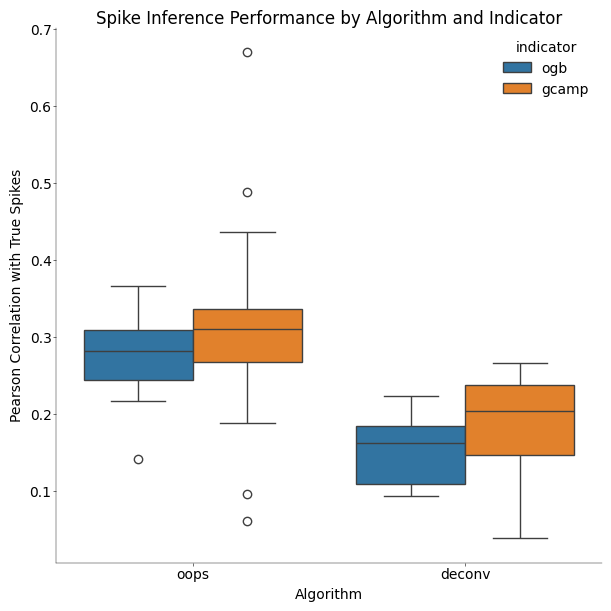

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")

# plot boxplot
sns.boxplot(data=df_eval, x="algorithm", y="correlation", hue="indicator", ax=ax)

# add labels and title
ax.set_title("Spike Inference Performance by Algorithm and Indicator")
ax.set_xlabel("Algorithm")
ax.set_ylabel("Pearson Correlation with True Spikes")


### Questions (1 pt)
1) Describe and explain the results briefly.

Generally, oops performs better than the simple deconvolution algorithm. This is expected, as oops is a more sophisticated algorithm that takes into account the non-linearities of the calcium signal. The simple deconvolution algorithm assumes a linear relationship between the calcium signal and the spike rate, which is not always the case. As a result, oops is able to recover the true spike rate more accurately than the simple deconvolution algorithm. Moreover, GCamp cells are easier to estimate their spike rate than OGB cells, both algorithms perform on average better with GCamp cells. Yet, the dispersion accross cells is larger for GCamp than OGB. Lastly, the overall performance is far from perfect, which can be explained by the calcium signal being a non-linear function of the spike rate. 